# Exercise 6: Markov Chain Monte Carlo

In [1033]:
import numpy as np
import math
from scipy.stats import chisquare
import scipy.stats as stats

## 1.
The number of busy lines in a trunk group (Erlang system) is given by a truncated Poisson distribution
$$
P(i)=c \cdot \frac{A^i}{i!}, \quad i=0, \ldots m
$$

Generate values from this distribution by applying the Metropolis-Hastings algorithm, verify with a $\chi^2$-test. You can use the parameter values from exercise 4 .

Chi-square statistic: 0.0017045977030947766
P-value: 1.0


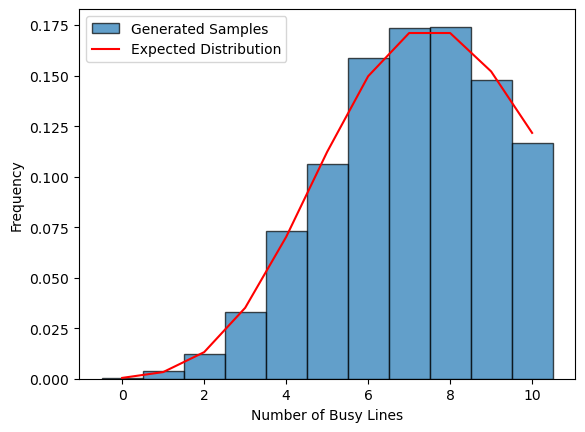

In [1035]:

def tp_pmf(i, A, m):
    return (A**i) / np.math.factorial(i)

def metropolis_hastings(A, m, n):
    X = np.zeros(n).astype(int)

    # Initial state
    X[0] = 1 
    for i in range(n-1):
        Xi = X[i] # current state
        Y = np.random.randint(0, m + 1) # New random state
        g_Xi = tp_pmf(Xi, A, m)
        g_Y = tp_pmf(Y, A, m)
        alpha = min(1, g_Y / g_Xi)

        U = np.random.uniform()
        if U <= alpha:
            X[i+1] = Y
        else:
            X[i+1] = Xi
    return X

# Parameters
A = 8
m = 10
n = 10_000

# Generate samples
X = metropolis_hastings(A, m, n)

# Verify with chi-square test
observed_freq, _ = np.histogram(X, bins=np.arange(m + 2) - 0.5, density=True)
observed_freq = observed_freq/np.sum(observed_freq)

expected_freq = [tp_pmf(i, A, m) for i in range(m + 1)]
expected_freq = expected_freq/np.sum(expected_freq)

chisq_stat, p_value = chisquare(observed_freq, f_exp=expected_freq)

print(f"Chi-square statistic: {chisq_stat}")
print(f"P-value: {p_value}")

# Plot histogram of the samples vs expected
import matplotlib.pyplot as plt
plt.hist(X, bins=np.arange(m + 2) - 0.5, density=True, alpha=0.7, edgecolor='black', label='Generated Samples')
plt.plot(np.arange(m + 1), expected_freq, 'r-', label='Expected Distribution')
plt.xlabel('Number of Busy Lines')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## 2.
For two different call types the joint number of occupied lines is given by
$$
P(i, j)=c \cdot \frac{A_1^i}{i!} \frac{A_2^j}{j!} \quad 0 \leq i+j \leq m
$$
You can use $A_1, A_2=4$ and $m=10$.

In all three cases test the distribution fit with a $\chi^2$ test. The system can be extended to an arbitrary dimension, and we can add restrictions on the different call types.

(a) Use Metropolis-Hastings, directly to generate variates from this distribution.

Chi-square statistic: 0.08729049874656575
P-value: 1.0


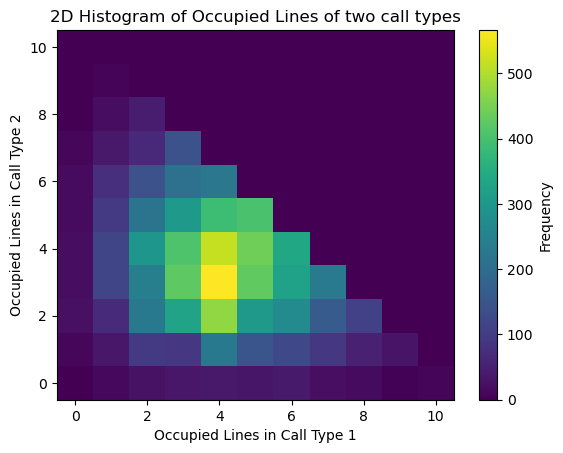

In [1037]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def tp_pmf(i, j, A1, A2, m):
    if i + j > m:
        return 0
    return (A1**i / np.math.factorial(i)) * (A2**j / np.math.factorial(j))

def metropolis_hastings(A1, A2, m, n):
    X1 = np.zeros(n).astype(int)
    X2 = np.zeros(n).astype(int)

    # Initial state
    X1[0] = 1 
    X2[0] = 2
    for i in range(n-1):
        X1i = X1[i] # current state
        X2i = X2[i] # current state
        
        Y1 = np.random.randint(0, m + 1) # New random state Y1
        Y2 = np.random.randint(0, m + 1 - Y1) # New random state Y2
        
        g_Xi = tp_pmf(X1i, X2i, A1, A2, m)
        g_Y = tp_pmf(Y1, Y2, A1, A2, m)
        alpha = min(1, g_Y / g_Xi)

        U = np.random.uniform()
        if U <= alpha:
            X1[i+1] = Y1
            X2[i+1] = Y2
        else:
            X1[i+1] = X1i
            X2[i+1] = X2i
    return X1, X2

# Parameters
A1, A2 = 4, 4
m = 10
n = 10_000

# Generate samples
X1, X2 = metropolis_hastings(A1, A2, m, n)

# Calculate observed frequencies
observed_freq, xedges, yedges = np.histogram2d(X1, X2, bins=[np.arange(m+2)-0.5, np.arange(m+2)-0.5], density=False)
observed_freq = observed_freq / np.sum(observed_freq)

# Calculate expected frequencies
expected_freq = np.zeros((m+1, m+1))
c = sum(tp_pmf(i, j, A1, A2, m) for i in range(m+1) for j in range(m+1) if i+j <= m)
for i in range(m+1):
    for j in range(m+1):
        if i + j <= m:
            expected_freq[i, j] = tp_pmf(i, j, A1, A2, m) / c
expected_freq = expected_freq / np.sum(expected_freq)

# Compute chi-squared statistic
mask = expected_freq > 0
chi_squared_stat = np.sum(((observed_freq[mask] - expected_freq[mask])**2) / expected_freq[mask])
df = np.sum(mask) - 1
p_value = 1 - chi2.cdf(chi_squared_stat, df)

# Print chi-squared test results
print(f"Chi-square statistic: {chi_squared_stat}")
print(f"P-value: {p_value}")

plt.hist2d(X1, X2, bins=[np.arange(m+2)-0.5, np.arange(m+2)-0.5], cmap='viridis')
plt.colorbar(label='Frequency')
plt.title('2D Histogram of Occupied Lines of two call types')
plt.xlabel('Occupied Lines in Call Type 1')
plt.ylabel('Occupied Lines in Call Type 2')
plt.show()


(b) Use Metropolis-Hastings, coordinate wise to generate variates from this distribution.

Chi-square statistic: 0.6040360665909799
P-value: 1.0


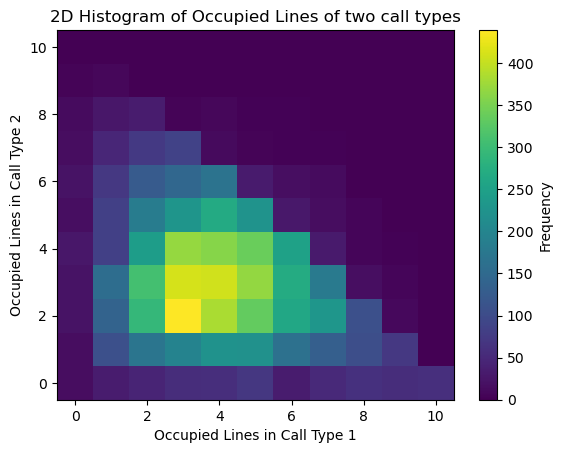

In [1039]:
def tp_pmf(i, A, m):
    return (A**i) / np.math.factorial(i)

def metropolis_hastings_coordinate(A1, A2, m, n):
    X1 = np.zeros(n).astype(int)
    X2 = np.zeros(n).astype(int)

    # Initial state
    X1[0] = 1 
    X2[0] = 2
    for i in range(n-1):
        X1i = X1[i] # current state
        X2i = X2[i] # current state
        
        Y1 = np.random.randint(0, m + 1) # New random state Y1
        Y2 = np.random.randint(0, m + 1 - Y1) # New random state Y2
        
        g_X1i = tp_pmf(X1i, A1, m)
        g_X2i = tp_pmf(X2i, A2, m)
        
        g_Y1 = tp_pmf(Y1, A1, m)
        g_Y2 = tp_pmf(Y2, A2, m)
        
        alpha1 = min(1, g_Y1 / g_X1i)
        alpha2 = min(1, g_Y2 / g_X2i)

        U = np.random.uniform()
        # First dimension
        if U <= alpha1:
            X1[i+1] = Y1
        else:
            X1[i+1] = X1i

        # Second dimension
        if U <= alpha2:
            X2[i+1] = Y2
        else:
            X2[i+1] = X2i

    return X1, X2

# Parameters
A1, A2 = 4, 4
m = 10
n = 10_000

# Generate samples
X1, X2 = metropolis_hastings_coordinate(A1, A2, m, n)

# Calculate observed frequencies
observed_freq, _, _ = np.histogram2d(X1, X2, bins=[np.arange(m+2)-0.5, np.arange(m+2)-0.5], density=False)
observed_freq = observed_freq / np.sum(observed_freq)

# Calculate expected frequencies
expected_freq = np.zeros((m+1, m+1))
c = sum(tp_pmf(i, A1, m) * tp_pmf(j, A2, m) for i in range(m+1) for j in range(m+1) if i+j <= m)
for i in range(m+1):
    for j in range(m+1):
        if i + j <= m:
            expected_freq[i, j] = (tp_pmf(i, A1, m) * tp_pmf(j, A2, m)) / c
expected_freq = expected_freq / np.sum(expected_freq)

# Compute chi-squared statistic
mask = expected_freq > 0
chi_squared_stat = np.sum(((observed_freq[mask] - expected_freq[mask])**2) / expected_freq[mask])
df = np.sum(mask) - 1
p_value = 1 - chi2.cdf(chi_squared_stat, df)

# Print chi-squared test results
print(f"Chi-square statistic: {chi_squared_stat}")
print(f"P-value: {p_value}")

plt.hist2d(X1, X2, bins=[np.arange(m+2)-0.5, np.arange(m+2)-0.5], cmap='viridis')
plt.colorbar(label='Frequency')
plt.title('2D Histogram of Occupied Lines of two call types')
plt.xlabel('Occupied Lines in Call Type 1')
plt.ylabel('Occupied Lines in Call Type 2')
plt.show()

(c) Use Gibbs sampling to sample from the distribution. This is (also) coordinate-wise but here we use the exact conditional
distributions. You will need to find the conditional distributions analytically.

Chi-square statistic: 0.005865586608894662
P-value: 1.0


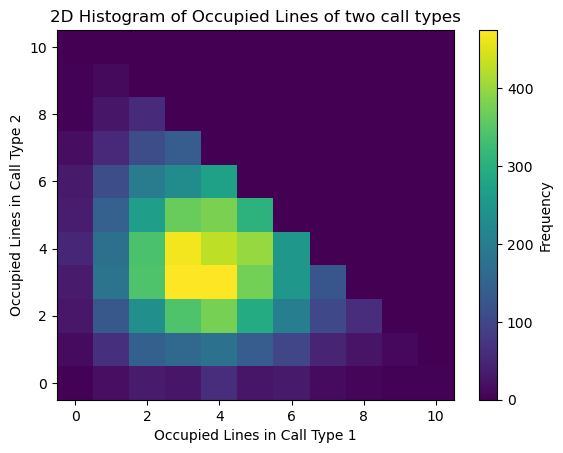

In [953]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def tp_pmf(i, A, m):
    return (A**i) / np.math.factorial(i)

def metropolis_hastings_gibbs(A1, A2, m, n):
    X1 = np.zeros(n).astype(int)
    X2 = np.zeros(n).astype(int)

    # Initial state
    X1[0] = 1 
    X2[0] = 2
    for i in range(n-1):
        X1i = X1[i] # current state
        X2i = X2[i] # current state
        
        # Sample Y1 from conditional distribution p(Y1|X2i)
        p_Y1_given_X2i = np.array([tp_pmf(y, A1, m) for y in range(m + 1 - X2i)])
        p_Y1_given_X2i = p_Y1_given_X2i / np.sum(p_Y1_given_X2i) # Normalize probabilities
        Y1 = np.random.choice(np.arange(m + 1 - X2i), p=p_Y1_given_X2i)
        
        # Sample Y2 from conditional distribution p(Y2|Y1)
        p_Y2_given_Y1 = np.array([tp_pmf(y, A2, m) for y in range(m + 1 - Y1)])
        p_Y2_given_Y1 = p_Y2_given_Y1 / np.sum(p_Y2_given_Y1) # Normalize probabilities
        Y2 = np.random.choice(np.arange(m + 1 - Y1), p=p_Y2_given_Y1)
        
        X1[i+1] = Y1
        X2[i+1] = Y2

    return X1, X2

# Parameters
A1, A2 = 4, 4
m = 10
n = 10_000

# Generate samples
X1, X2 = metropolis_hastings_gibbs(A1, A2, m, n)

# Calculate observed frequencies
observed_freq, xedges, yedges = np.histogram2d(X1, X2, bins=[np.arange(m+2)-0.5, np.arange(m+2)-0.5], density=False)
observed_freq = observed_freq / np.sum(observed_freq)

# Calculate expected frequencies
expected_freq = np.zeros((m+1, m+1))
c = sum(tp_pmf(i, A1, m) * tp_pmf(j, A2, m) for i in range(m+1) for j in range(m+1) if i+j <= m)
for i in range(m+1):
    for j in range(m+1):
        if i + j <= m:
            expected_freq[i, j] = (tp_pmf(i, A1, m) * tp_pmf(j, A2, m)) / c
expected_freq = expected_freq / np.sum(expected_freq)

# Compute chi-squared statistic
mask = expected_freq > 0
chi_squared_stat = np.sum(((observed_freq[mask] - expected_freq[mask])**2) / expected_freq[mask])
df = np.sum(mask) - 1
p_value = 1 - chi2.cdf(chi_squared_stat, df)

# Print chi-squared test results
print(f"Chi-square statistic: {chi_squared_stat}")
print(f"P-value: {p_value}")

plt.hist2d(X1, X2, bins=[np.arange(m+2)-0.5, np.arange(m+2)-0.5], cmap='viridis')
plt.colorbar(label='Frequency')
plt.title('2D Histogram of Occupied Lines of two call types')
plt.xlabel('Occupied Lines in Call Type 1')
plt.ylabel('Occupied Lines in Call Type 2')
plt.show()


## 3.
We consider a Bayesian statistical problem. The observations are $X_i \sim \mathrm{N}(\Theta, \Psi)$, where the prior distribution of the pair $(\Xi, \Gamma)=(\log (\Theta), \log (\Psi))$ is standard normal with correlation
$\rho=\frac{1}{2}$. The joint density $f(x, y)$ of $(\Theta, \Psi)$ is
$$
f(x, y)=\frac{1}{2 \pi x y \sqrt{1-\rho^2}} e^{-\frac{\log (x)^2-2 \rho \log (x) \log (y)+\log (y)^2}{2\left(1-\rho^2\right)}}
$$
which can be derived using a standard change of variable technique. The task of this exercise is now to sample from the posterior distribution of $(\Theta, \Psi)$ using Markov Chain Monte Carlo.

(a) Generate a pair $(\theta, \psi)$ from the prior distribution, i.e. the distribution for the pair $(\Theta, \Psi)$, by first generating a sample $(\xi, \gamma)$ of $(\Xi, \Gamma)$.

(b) Generate $X_i=1, \ldots, n$ with the values of $(\theta, \psi)$ you obtained in item 3a. Use $n=10$.

(c) Derive the posterior distribution of $(\Theta, \Psi)$ given the sample. **Hint 1:** Apply Bayes theorem in the density version.
**Hint 2:** The sample mean and sample variance are independent. The sample mean follows a normal distribution, while a scaled version of the sample variance follows a $\chi^2$ distribution. This can be used to simplify the expression.

(d) Generate MCMC samples from the posterior distribution of $(\Theta, \Psi)$ using the Metropolis Hastings method.

(e) Repeat item 3d with $n=100$ and $n=1000$, still using the values of $(\theta, \psi)$ from item 3a. Discuss the results.

In [1041]:
## a) ##

def theta_psi_generator():
    # Independent standard normal random variables
    Z1 = np.random.normal(size=1)
    Z2 = np.random.normal(size=1)
    
    rho = 0.5
    
    # Compute xi and gamma via linear transformation
    xi = Z1
    gamma = rho * Z1 + np.sqrt(1 - rho**2) * Z2
    
    # Transform xi and gamma with the exponent to get theta and psi
    theta = np.exp(xi)[0]
    psi = np.exp(gamma)[0]
    return theta, psi

theta, psi = theta_psi_generator()
print(f"The generated pair is (theta, psi) = ({theta},{psi})")

The generated pair is (theta, psi) = (2.529731488758029,0.6235970691686756)


In [1043]:
## b) ##
n = 10
X = np.random.normal(theta, psi, size=n)
print(f"Sample:\n {X}")

Sample:
 [2.99103603 2.29648735 3.52619192 3.00003241 3.11384936 3.10096323
 1.68566458 2.22246747 2.0965884  2.99505705]


**Solution to (c):**

We want to derive the posterior distribution of $(\Theta, \Psi)$ given $X_i=1, \ldots, n$, which can be written as $$f\left(\theta, \psi \mid X_1, X_2, \ldots, X_n\right).$$

Applying Bayes theorem we get

$$f\left(\theta, \psi \mid X_1, X_2, \ldots, X_n\right)=\frac{f\left(X_1, X_2, \ldots, X_n \mid \theta, \psi\right) \cdot f(\theta, \psi)}{f\left(X_1, X_2, \ldots, X_n\right)}$$

where
- $f\left(X_1, X_2, \ldots, X_n \mid \theta, \psi\right)$ is the likelihood function
- $f(\theta, \psi)$ is the joint density given in the exercise
- $f\left(X_1, X_2, \ldots, X_n\right)$ is the marginal likelihood

Given Hint 2, we can express the likelihood function using the distributions of the sample mean and the scaled sample variance. Specifically:
- The sample mean $\bar{X}$ follows a normal distribution $N\left(\theta, \frac{\psi}{n}\right)$.
- The scaled sample variance $S^2$ follows a $\chi^2$ distribution with $n-1$ degrees of freedom.
- And they are independent!

Therefore, the likelihood function $f\left(X_1, X_2, \ldots, X_n \mid \theta, \psi\right)$ can be expressed as the product of the PDF of the normal distribution for the sample mean and the PDF of the $\chi^2$ distribution for the scaled sample variance and when multiplied with the joint density function we get the posterior distribution of $(\theta, \psi)$ given the sample.

In [1045]:
## c) ##

from scipy.stats import norm, chi2

# Prior distribution parameters
rho = 0.5

def likelihood(X, theta, psi):
    n = len(X)
    sample_mean = np.mean(X)
    sample_variance = np.var(X, ddof=1)
    pdf_mean = norm.pdf(sample_mean, loc=theta, scale=np.sqrt(psi / n))
    pdf_variance = chi2.pdf((n - 1) * sample_variance / psi, df=n - 1)
    return pdf_mean * pdf_variance

def prior_density(theta, psi):
    return (1 / (2 * np.pi * theta * psi * np.sqrt(1 - rho**2))) * \
           np.exp((-np.log(theta)**2 - 2 * rho * np.log(theta) * np.log(psi) + np.log(psi)**2) /
                  (2 * (1 - rho**2)))

def posterior_density(X, theta, psi):
    return likelihood(X, theta, psi) * prior_density(theta, psi)

# Compute the posterior for the pair from 3a
posterior = posterior_density(X, theta, psi)

print("Posterior distribution:", posterior)


Posterior distribution: 0.010953792529188598


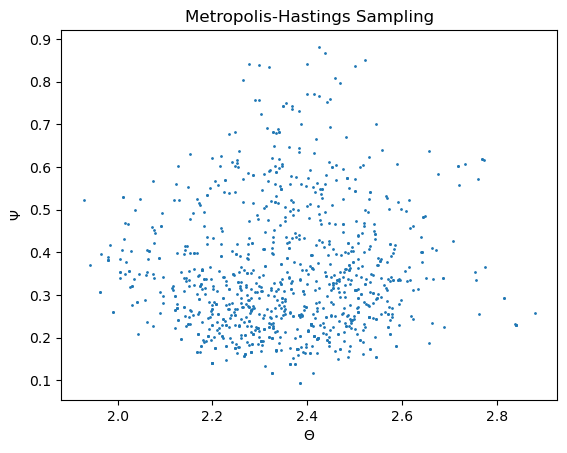

In [1125]:
import numpy as np
from scipy.stats import norm, chi2

def metropolis_hastings(X, initial_theta, initial_psi, iterations=10000):
    theta_s = np.zeros(iterations)
    psi_s = np.zeros(iterations)

    # Initial state
    theta_s[0] = initial_theta
    psi_s[0] = initial_psi
    
    for i in range(iterations - 1):
        theta_current = theta_s[i]
        psi_current = psi_s[i]
        
        # proposed_theta = np.random.normal(theta_current, 0.1)
        # proposed_psi = np.random.normal(psi_current, 0.1)

        proposed_theta = theta_current + np.random.uniform(-0.1, 0.1)
        proposed_psi = psi_current + np.random.uniform(-0.1, 0.1)

        # Ensure proposed values are positive
        proposed_theta = max(proposed_theta, 1e-6)
        proposed_psi = max(proposed_psi, 1e-6)
        
        g_X = posterior_density(X, theta_current, psi_current)
        g_Y = posterior_density(X, proposed_theta, proposed_psi)

        alpha = min(1, g_Y / g_X)

        U = np.random.uniform()
        if U <= alpha:
            theta_s[i+1] = proposed_theta
            psi_s[i+1] = proposed_psi
        else:
            theta_s[i+1] = theta_current
            psi_s[i+1] = psi_current
            
    return theta_s, psi_s

# Parameters
n = 10
iterations = 1000

# Generate data
X = np.random.normal(loc=theta, scale=np.sqrt(psi), size=n)

# Initial values for Metropolis-Hastings
initial_theta = theta
initial_psi = psi

# Run Metropolis-Hastings
theta_s, psi_s = metropolis_hastings(X, initial_theta, initial_psi, iterations)

# Display results
import matplotlib.pyplot as plt

plt.plot(theta_s, psi_s, 'o', markersize=1)
plt.title('Metropolis-Hastings Sampling')
plt.xlabel(r'$\Theta$')
plt.ylabel(r'$\Psi$')
plt.show()


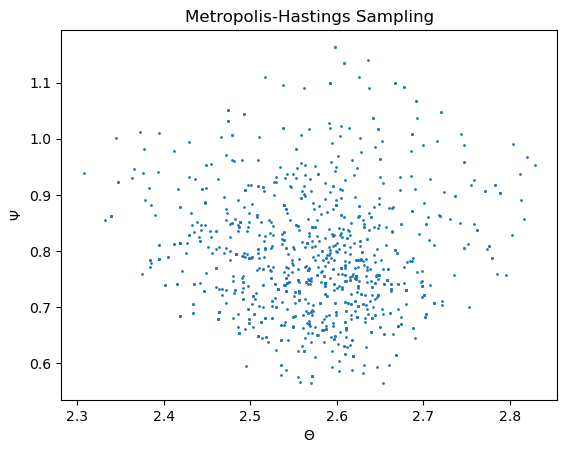

In [1127]:
# Parameters
n = 100
iterations = 1000

# Generate data
X = np.random.normal(loc=theta, scale=np.sqrt(psi), size=n)

# Initial values for Metropolis-Hastings
initial_theta = theta
initial_psi = psi

# Run Metropolis-Hastings
theta_s, psi_s = metropolis_hastings(X, initial_theta, initial_psi, iterations)

plt.plot(theta_s, psi_s, 'o', markersize=1)
plt.title('Metropolis-Hastings Sampling')
plt.xlabel(r'$\Theta$')
plt.ylabel(r'$\Psi$')
plt.show()

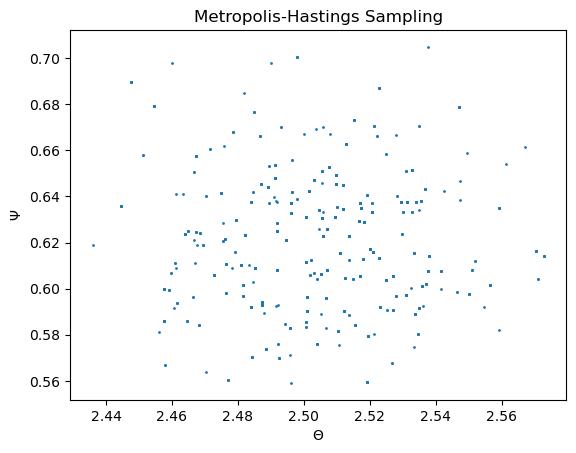

In [1129]:
# Parameters
n = 1000
iterations = 1000

# Generate data
X = np.random.normal(loc=theta, scale=np.sqrt(psi), size=n)

# Initial values for Metropolis-Hastings
initial_theta = theta
initial_psi = psi

# Run Metropolis-Hastings
theta_s, psi_s = metropolis_hastings(X, initial_theta, initial_psi, iterations)

plt.plot(theta_s, psi_s, 'o', markersize=1)
plt.title('Metropolis-Hastings Sampling')
plt.xlabel(r'$\Theta$')
plt.ylabel(r'$\Psi$')
plt.show()